In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import glob
import numpy as np


In [5]:
''' Constants '''
img_dir = '../datasets/image-data/images'
annotations_path = '../datasets/image-data/annotations/'
img_size = 200

In [6]:
''' import images '''
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (img_size, img_size))
    X.append(np.array(img))
    

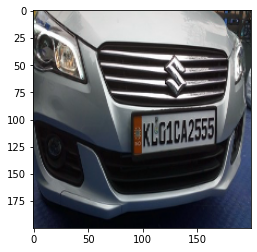

In [7]:
plt.imshow(X[0])

In [8]:
''' import annotations '''
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/img_size)
        ymin = int(dim.xpath("ymin")[0].text)/(height/img_size)
        xmax = int(dim.xpath("xmax")[0].text)/(width/img_size)
        ymax = int(dim.xpath("ymax")[0].text)/(height/img_size)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

text_files = [annotations_path+f for f in sorted(os.listdir(annotations_path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

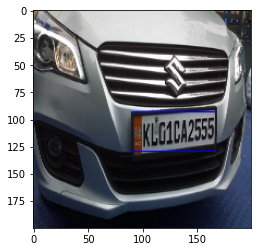

In [9]:
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [10]:
class plate_recognition:
    def __init__(self):
        self.image_data = None
        self.annotation_data = None
        

In [11]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [12]:
#Renormalisation
X = X / 255
y = y / 255

# Convolutional Neural Network

In [13]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [21]:
def createMode():
    model = Sequential()
    model.add(VGG16(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="sigmoid"))

    model.layers[-6].trainable = False

#     model.summary()
    return model

In [22]:
def trainModel(model, X, Y):
    model.compile(
        loss='mean_squared_error',
        optimizer='adam', 
        metrics=['accuracy']
    )
    train = model.fit(
        X,
        y, 
        validation_split=0.3, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        workers=8, 
        use_multiprocessing=True
    )
    return model

In [24]:
# Create the model
model = None
if "saved_model.pb" in os.listdir('./models'):
    print('working')
    model = tf.keras.models.load_model('./models')
else:
    model = createModel()
    model = trainModel(model, X, Y)
    model.save("./models/weights/model.pb")

working


In [33]:
predicted_y = model.predict(X[0:2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


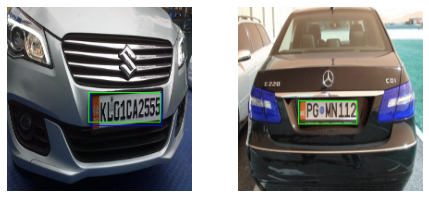

In [35]:
plt.figure(figsize=(20,40))
for i in range(0,2) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = predicted_y[i]*255
    image = cv2.rectangle(X[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)